In [1]:
library(xts)
library(dplyr)
library(quantmod)
library(vars)
library(tseries)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:xts':

    first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'quantmod' was built under R version 3.6.3"Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.6.3"Loading requ

## Data wrangling

You can simply skip this part and go directly to "Analysis" chapter.

In [33]:
# Mosprime rate from nfea

df_1 <- read.csv("mosprime.csv", header = TRUE, sep = ";", dec = ",")
names(df_1)[1] <- 'Dates'
names(df_1)[7] <- 'mp'
drops_1 <- c("X","X.1", "X.2", "X.3", "X.4", "X.6", "X.7")
df <- df_1[ , !(names(df_1) %in% drops_1)]
df <- df_1[-c(1), ]

#  Convert to date if not already
df_1$Dates <- as.Date(df_1$Dates, format = "%d-%m-%Y")
df_1$mp <- as.numeric(gsub(",", ".", gsub("\\.", "", df_1$mp)))
df_1 <- df_1[-c(1), ]

#Create ts object
mp_ts <- xts(x = df_1$mp, order.by = df_1$Dates)

Warning message in eval(expr, envir, enclos):
"в результате преобразования созданы NA"

,Dates,X,X.1,X.2,X.3,X.4,mp,X.6,X.7
2,2021-11-19,"7,61","7,75","7,80","7,99","8,25",8.52,"8,66",NA
3,2021-11-18,"7,65","7,76","7,80","8,00","8,26",8.52,"8,67",NA
4,2021-11-17,"7,62","7,72","7,78","7,99","8,24",8.48,"8,63",NA
5,2021-11-16,"7,63","7,69","7,77","8,00","8,23",8.49,"8,68",NA
6,2021-11-15,"7,58","7,68","7,77","7,99","8,22",8.48,"8,63",NA
7,2021-11-12,"7,56","7,68","7,76","7,99","8,23",8.48,"8,64",NA


In [34]:
# We use 2-year term because it's more sensitive to exchange rate risks.

df_2 <- read.csv("nfea_swap_rate.csv", header = TRUE, sep = ";", dec = ",")
names(df_2)[1] <- 'Dates'
names(df_2)[11] <- 'sr'
drops_2 <- c("X","X.1", "X.2", "X.3", "X.4", "X.5", "X.6", "X.7", "X.8", "X.10", "X.11", "X.12", "X.13")
df_2 <- df_2[ , !(names(df_2) %in% drops_1)]
df_2 <- df_2[-c(1), ]
df_2$Dates <- as.Date(df_2$Dates, format = "%d-%m-%Y")
df_2$sr <- as.numeric(gsub(",", ".", gsub("\\.", "", df_2$sr)))

sr_ts <- xts(x = df_2$sr, order.by=df_2$Dates)

In [35]:
# Bank of Russia policy rate form BIS site.

df_3 <- read.csv("policy_rate.csv", header = FALSE, sep = ";", dec = ",")

#Creating time sequence

st <- as.Date("2013-02-1")
en <- as.Date("2021-11-1")
dates <- seq(st, en, by = "month")

pr_monthly <- xts(x = df_3$V1, order.by = dates)

In [36]:
# Crude oil daily data

getSymbols("DCOILBRENTEU", src = "FRED", from = "2013-02-19")
brent <- DCOILBRENTEU["2013-02-19/"]
brent <- na.approx(brent)
brent_monthly <- apply.monthly(brent, mean)

# Detrended normalized GDP monthly data
getSymbols("RUSLORSGPRTSTSAM", src = "FRED", from = "2013-02-19")
gdp <- RUSLORSGPRTSTSAM["2013-02/"]

[1] "DCOILBRENTEU"

[1] "RUSLORSGPRTSTSAM"

In [37]:
# Creating monthly data for mosprime and nfea swap rates

mp_monthly <- apply.monthly(mp_ts, mean)
sr_monthly <- apply.monthly(sr_ts, mean)

In [38]:
# Merging our series for future VARs

st <- as.Date("2013-02-1")
en <- as.Date("2021-05-1")
dates <- seq(st, en, by = "month")

mp_monthly <- mp_monthly["2013-02/2021-05"]
mp_monthly <- xts(mp_monthly, order.by = dates)
head(mp_monthly)

sr_monthly <- sr_monthly["2013-02/2021-05"]
brent_monthly <- brent_monthly["2013-02/2021-05"]
pr_monthly <- pr_monthly["2013-02/2021-05"]

sr_monthly <- xts(sr_monthly, order.by = dates)
brent_monthly <- xts(brent_monthly, order.by = dates)
pr_monthly <- xts(pr_monthly, order.by = dates)
gdp_monthly <- xts(gdp, order.by = dates)

data <- merge(mp_monthly, sr_monthly, brent_monthly, pr_monthly, gdp_monthly)
names(data) = c("MP", "SR", "Brent", "PR", "GDP")

na.approx(data)

head(data)

                  x
2013-02-01 7.067000
2013-03-01 7.068000
2013-04-01 7.201364
2013-05-01 7.160000
2013-06-01 7.052105
2013-07-01 7.005217

                  MP        SR     Brent    PR       GDP
2013-02-01  7.067000  6.017500 114.14375  8.25 101.44463
2013-03-01  7.068000  6.216842 108.47690  8.25 101.47443
2013-04-01  7.201364  5.821818 102.24818  8.25 101.48869
2013-05-01  7.160000  5.838889 102.58380  8.25 101.48714
2013-06-01  7.052105  6.528947 102.91950  8.25 101.47436
2013-07-01  7.005217  6.292174 107.88348  8.25 101.46044
2013-08-01  6.856818  6.242727 111.28045  8.25 101.45560
2013-09-01  6.792857  6.373810 111.78762  8.25 101.46502
2013-10-01  6.797826  6.375652 109.07652  5.50 101.48339
2013-11-01  6.863500  6.552500 107.95405  5.50 101.50155
2013-12-01  7.078636  6.555455 110.79545  5.50 101.51284
2014-01-01  7.042941  6.729412 108.15370  5.50 101.51954
2014-02-01  7.115500  7.338500 108.94362  5.50 101.52605
2014-03-01  9.005000  8.834500 107.48095  5.50 101.53243
2014-04-01  9.279091  8.900000 107.84659  7.00 101.52835
2014-05-01  9.802105  9.040000 109.53909  7.50 101.49896
2014-06-01  9.570000  8.542632 

                 MP       SR    Brent   PR      GDP
2013-02-01 7.067000 6.017500 114.1437 8.25 101.4446
2013-03-01 7.068000 6.216842 108.4769 8.25 101.4744
2013-04-01 7.201364 5.821818 102.2482 8.25 101.4887
2013-05-01 7.160000 5.838889 102.5838 8.25 101.4871
2013-06-01 7.052105 6.528947 102.9195 8.25 101.4744
2013-07-01 7.005217 6.292174 107.8835 8.25 101.4604

## Analysis

At first, we need to make our data stationary. Let's run a simple loop over our series.

In [39]:
for (i in 1:5){
data[,i] = 400 * Delt(data[,i], typ = "log")
    }
data <- na.omit(data)

# The Study Itself:

**The plan of our study is the following:**

* Select the order of our VAR model.
* Estimate VAR and see what we can build on.
* Test our VAR.
* Select a proper structural model and estimate it.
* Draw conclusions.

In [45]:
VARselect(data)

,1,2,3,4,5,6,7,8,9,10
AIC(n),2.473077e+01,2.464757e+01,2.465780e+01,2.474996e+01,2.497472e+01,2.495312e+01,2.515823e+01,2.516554e+01,2.513581e+01,2.451772e+01
HQ(n),2.506889e+01,2.526746e+01,2.555946e+01,2.593339e+01,2.643991e+01,2.670009e+01,2.718697e+01,2.747605e+01,2.772808e+01,2.739177e+01
SC(n),2.556964e+01,2.618549e+01,2.689478e+01,2.768599e+01,2.860980e+01,2.928727e+01,3.019143e+01,3.089779e+01,3.156711e+01,3.164808e+01
FPE(n),5.506576e+10,5.094018e+10,5.215851e+10,5.867441e+10,7.663763e+10,7.999426e+10,1.077839e+11,1.236185e+11,1.432189e+11,9.794431e+10


In [46]:
data_var <- VAR(data, p = 1)
summary(data_var)


VAR Estimation Results:
Endogenous variables: MP, SR, Brent, PR, GDP 
Deterministic variables: const 
Sample size: 98 
Log Likelihood: -1918.436 
Roots of the characteristic polynomial:
0.597 0.597 0.4048 0.4048 0.09093
Call:
VAR(y = data, p = 1)


Estimation results for equation MP: 
MP = MP.l1 + SR.l1 + Brent.l1 + PR.l1 + GDP.l1 + const 

         Estimate Std. Error t value Pr(>|t|)   
MP.l1     0.17131    0.14564   1.176   0.2425   
SR.l1     0.49887    0.16641   2.998   0.0035 **
Brent.l1  0.01785    0.05676   0.314   0.7539   
PR.l1    -0.20094    0.07748  -2.593   0.0111 * 
GDP.l1   -0.57454    1.97060  -0.292   0.7713   
const    -1.15588    2.45975  -0.470   0.6395   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 24.22 on 92 degrees of freedom
Multiple R-Squared: 0.3189,	Adjusted R-squared: 0.2819 
F-statistic: 8.616 on 5 and 92 DF,  p-value: 9.995e-07 


Estimation results for equation SR: 
SR = MP.l1 + SR.l1 + Brent.l1 + PR.l1

## Impulse Response Functions

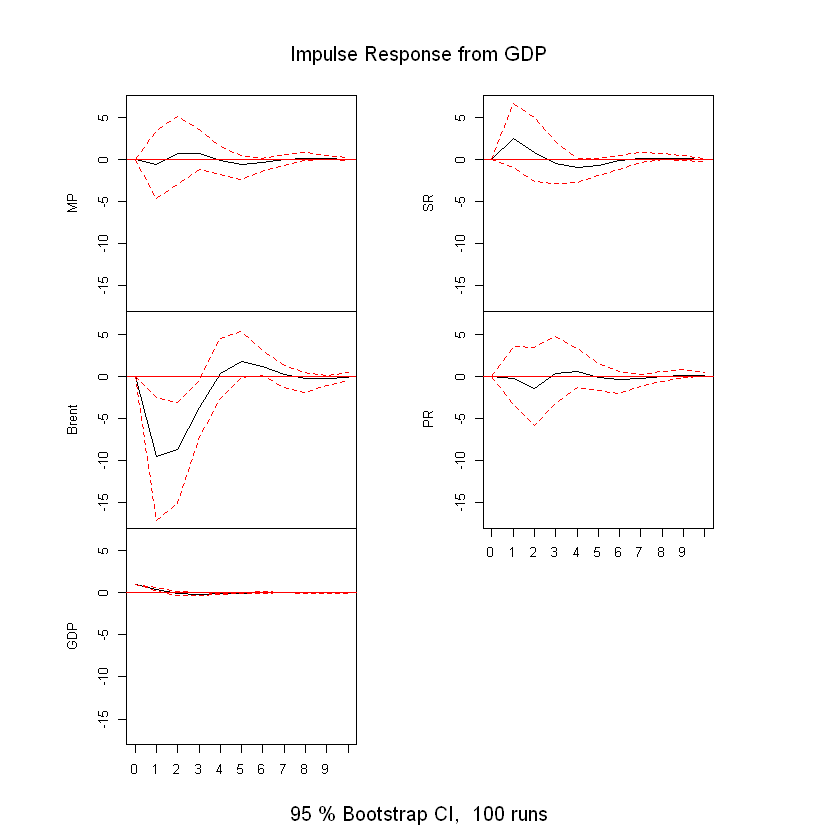

In [47]:
plot(irf(data_var, impulse = "GDP", boot = 500, ortho = F))

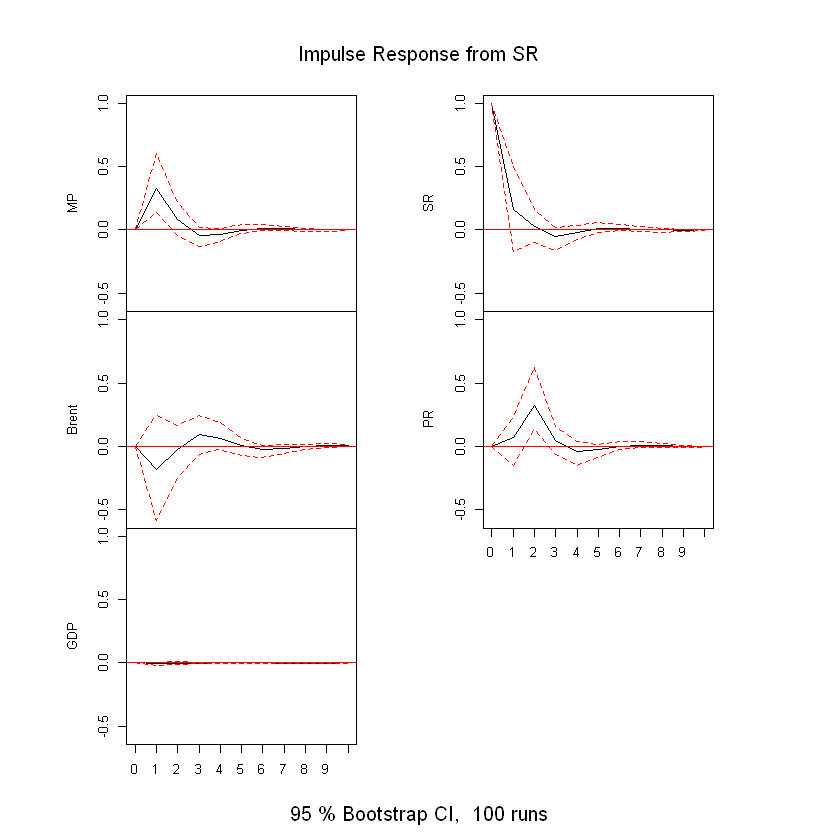

In [460]:
plot(irf(data_var, impulse = "SR", boot = 500, ortho = F))

## Testing our VAR model:

### Heteroscedasticity test

In [56]:
Arch1 <- arch.test(data_var, lags.multi = 12, multivariate.only = TRUE)
Arch1


	ARCH (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 1290, df = 2700, p-value = 1

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 1290, df = 2700, p-value = 1



Test suggests **H0** (no time-varying dispersion of data) **holds**, which is great!

### Test for serial correlation

**Portmaneau test (Ljuing-Box Test)**

**H0:** The data are independently distributed. $\rho_1 = \rho_2 = ... = \rho_m =0$

**Ha:** The data are not independently distributed. They exhibit serial serial correlation. Some $\rho_k \neq 0$

In [57]:
Serial <- serial.test(data_var, lags.pt = 12, type = "PT.asymptotic")
Serial


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object data_var
Chi-squared = 230.51, df = 275, p-value = 0.9762

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object data_var
Chi-squared = 230.51, df = 275, p-value = 0.9762



The test suggest our **H0 holds**, which is also great!

### Test for residuals normality:

Jarque-Bera test (goodness-of-fit)

**H0:** The data (the residuals of the model) is nornally distributed

**Ha:** The data is not normally distributed

In [58]:
Norm <- normality.test(data_var, multivariate.only = TRUE)
Norm

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 8767.8, df = 10, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 651.35, df = 5, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 8116.4, df = 5, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 8767.8, df = 10, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 651.35, df = 5, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object data_var
Chi-squared = 8116.4, df = 5, p-value < 2.2e-16




**HO is rejected!** That's a bad feature of the model, that we can't challenge in our study :(

### Testing for structural breaks in the residuals

Is the system of difference equations stable?

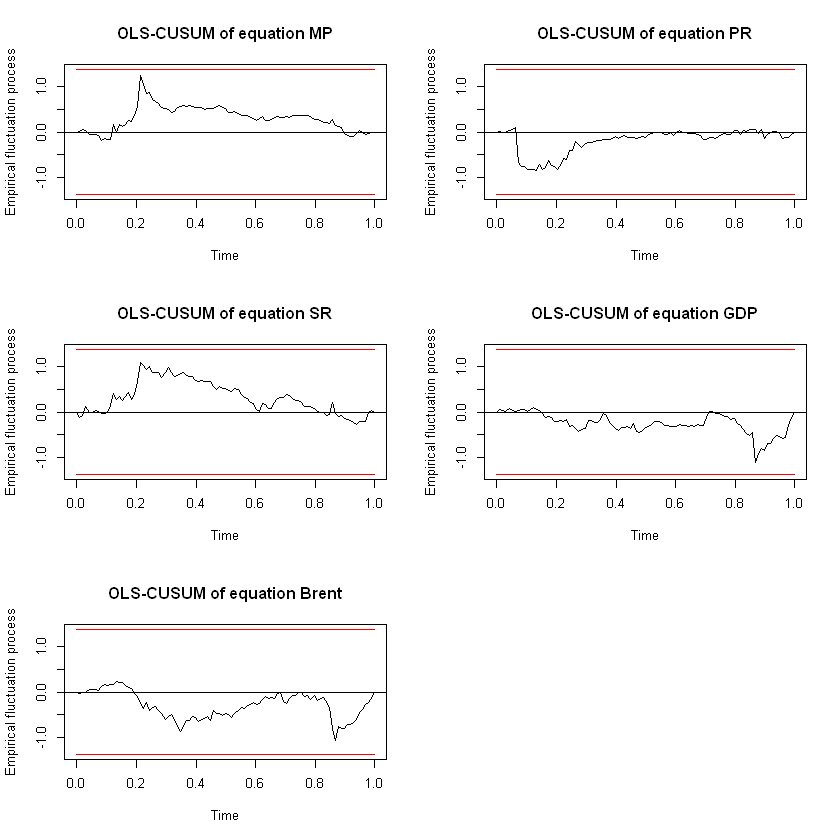

In [59]:
stability <- stability(data_var, type = "OLS-CUSUM")
plot(stability)

We can conclude, that the system is stable, which is great!

## Granger causality:

In [62]:
library(lmtest)

In [64]:
grangertest(MP ~ SR, order = 3, data = data)

Res.Df,Df,F,Pr(>F)
89,NA,NA,NA
92,-3,3.3413,0.02279336


**H0 is rejected**. Swap Rate Granger-cause MosPrime Rate!

In [65]:
grangertest(MP ~ Brent, order = 3, data = data)

Res.Df,Df,F,Pr(>F)
89,NA,NA,NA
92,-3,1.223859,0.3057878


**H0 holds**. Oil prices do not Granger-cause MosPrime Rate!

In [66]:
grangertest(MP ~ PR, order = 3, data = data)

Res.Df,Df,F,Pr(>F)
89,NA,NA,NA
92,-3,1.418119,0.2427779


In [67]:
grangertest(MP ~ GDP, order = 3, data = data)

Res.Df,Df,F,Pr(>F)
89,NA,NA,NA
92,-3,1.23992,0.3000532


### Building SVAR Model

Let's apply some theoretical foundations and constraint our VAR model!

We have the following variables: MP, SR, Brent, PR, GDP

In [42]:
amat <- diag(5)

amat[1,2] <- NA
amat[1,3] <- NA
amat[1,4] <- NA
amat[1,5] <- NA

amat[2,1] <- NA
amat[2,3] <- NA
amat[2,4] <- NA
amat[2,5] <- NA

amat[4,5] <- NA

amat[5,3] <- NA
amat[5,4] <- NA

amat

1,NA,NA,NA,NA
NA,1,NA,NA,NA
0,0,1,0,0
0,0,0,1,NA
0,0,NA,NA,1


In [48]:
SVAR_Mod <- SVAR(data_var, Amat = amat, bmat = NULL, hessian = TRUE, estmethod = c("scoring", "direct"))
SVAR_Mod

Warning message in SVAR(data_var, Amat = amat, bmat = NULL, hessian = TRUE, estmethod = c("scoring", :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."


SVAR Estimation Results:


Estimated A matrix:
           MP      SR    Brent        PR    GDP
MP     1.0000 -0.3962 -0.28107 -0.037128 1.0358
SR    -0.5217  1.0000  0.56765 -0.071274 1.8638
Brent  0.0000  0.0000  1.00000  0.000000 0.0000
PR     0.0000  0.0000  0.00000  1.000000 0.7477
GDP    0.0000  0.0000 -0.01639 -0.001077 1.0000

Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod = c("scoring", "direct"), Amat = amat, :
"Convergence not achieved after 100 iterations. Convergence value: 1 ."Warning message in SVAR(x = varboot, estmethod

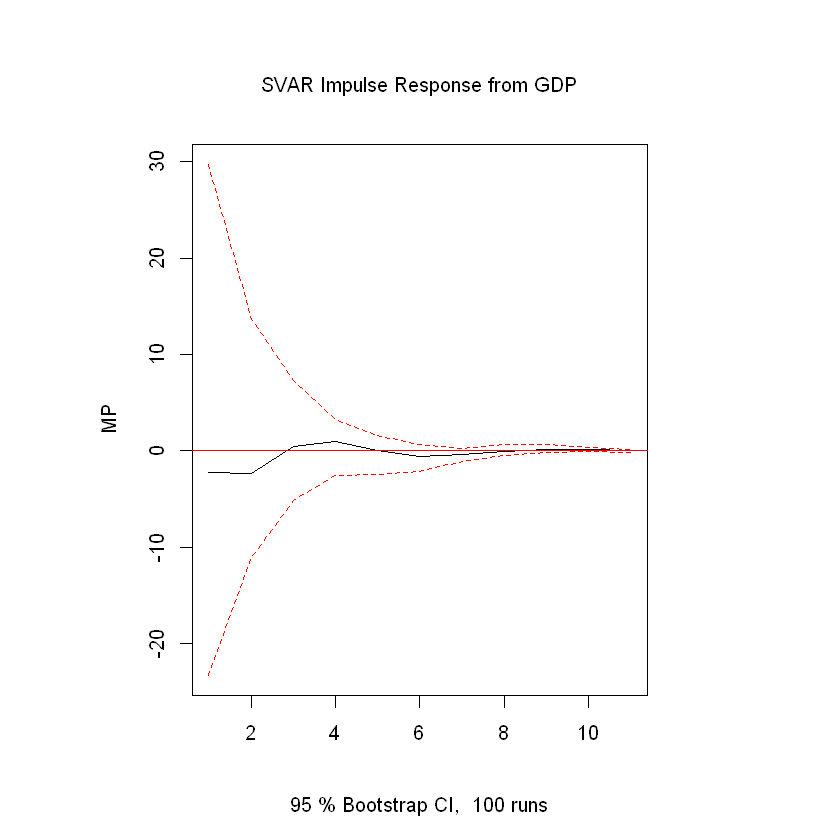

In [54]:
SVAR_irf <- irf(SVAR_Mod, impulse = "GDP", response = "MP")
plot(SVAR_irf)